In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

# Path to the filtered CSV file
combine = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset_utk_fgnet_morph_allface.csv'

# Read the filtered CSV file into a DataFrame
combine = pd.read_csv(combine)

# Display the first few rows of the DataFrame to verify the contents
combine

,filename,age,gender,ethnicity
0,078A12_1.JPG,12,1,W
1,078A05_1.JPG,5,1,W
2,077A15_0.JPG,15,0,W
3,076A01_0.JPG,1,0,W
4,075A06_1.JPG,6,1,W
...,...,...,...,...
12209,282278_04M20.JPG,20,1,B
12210,326393_02M19.JPG,19,1,W
12211,326759_03M18.JPG,18,1,W
12212,330586_03M16.JPG,16,1,W


In [ ]:
import pandas as pd
import os

# Path to the filtered CSV file
combine_path = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset_utk_fgnet_morph_allface.csv'

# Read the filtered CSV file into a DataFrame
combine_df = pd.read_csv(combine_path)

# Define paths
image_folder = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset/db_final_5000_viola'
annotated_folder = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/images_annotated'
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/features_with_filenames.csv'




In [ ]:
!pip install dlib
!pip install menpo menpofit



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.7/168.7 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for menpo: filename=menpo-0.11.1-py3-none-any.whl size=1611858 sha256=e8facd448e77e601dbf54939fd190fd17edd3024a63520efd2588ed58bd5a40f
  Stored in directory: /root/.cache/pip/wheels/16/48/f0/92c6393a62993b504063ca372e77149f05f1964db1fd0639d3
  Created wheel for menpofit: filename=menpofit-0.7.1-py3-none-any.whl size=206710 sha256=e265f7cf699f8e3d06defcc0b7041922e6b0e75e597cfcd6cc17552c9b395ef0
  Stored in directory: /root/.cache/pip/wheels/d7/41/96/ac0703cbedddf1b703af2e3fdcdb7f525f642bbe100b1212b6
Successfully built menpo menpofit


In [ ]:
import dlib
import cv2

# Path to the dlib pre-trained shape predictor model
shape_predictor_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/shape_predictor_68_face_landmarks.dat'

# Initialize dlib's face detector (HOG-based) and the shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)


In [ ]:
from menpo.image import Image
from menpo.shape import PointCloud
import numpy as np

# Function to detect landmarks using dlib
def detect_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) > 0:
        shape = predictor(gray, rects[0])
        landmarks = np.array([[shape.part(i).x, shape.part(i).y] for i in range(68)])
        return landmarks
    else:
        return None

# Function to draw landmarks on the image
def draw_landmarks(image, landmarks):
    for (x, y) in landmarks:
        cv2.circle(image, (x, y), 1, (0, 255, 0), -1)
    return image

# Function to resize images and landmarks
def resize_image(image, size=(100, 100)):
    return cv2.resize(image, size)

def resize_landmarks(landmarks, original_shape, target_shape=(100, 100)):
    scaling_factor = np.array(target_shape) / np.array(original_shape)
    resized_landmarks = landmarks * scaling_factor
    return resized_landmarks

# Function to extract features from a single image
def extract_features(img_rgb, landmark, filename):
    img_rgb_resized = resize_image(img_rgb)
    landmarks_resized = resize_landmarks(landmark, img_rgb.shape[:2])
    menpo_img = Image(img_rgb_resized.astype(float) / 255.0)
    menpo_img.landmarks['PTS'] = PointCloud(landmarks_resized)
    features = menpo_img.as_vector()
    return np.append(features, filename)


In [ ]:
# Open the CSV file to write features
with open(features_output_path, 'a') as f:
    # Write header if the file is empty
    if os.stat(features_output_path).st_size == 0:
        header = ",".join([f"feature_{i}" for i in range(100 * 100 * 3 * 2)] + ["filename"])
        f.write(header + "\n")

    for idx, row in combine_df.iterrows():
        img_path = os.path.join(image_folder, row['filename'])
        annotated_img_path = os.path.join(annotated_folder, row['filename'])

        # Check if the annotated image already exists
        if not os.path.exists(annotated_img_path):
            img = cv2.imread(img_path)

            if img is not None:
                landmark = detect_landmarks(img)

                if landmark is not None:
                    # Draw landmarks on the image
                    annotated_img = draw_landmarks(img.copy(), landmark)

                    # Save the annotated image
                    cv2.imwrite(annotated_img_path, annotated_img)

                    # Extract features and save to CSV
                    features = extract_features(img, landmark, row['filename'])
                    features_str = ",".join(map(str, features))
                    f.write(features_str + "\n")


In [ ]:
import pandas as pd
import os
import dlib
import cv2
from menpo.image import Image
from menpo.shape import PointCloud
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Path to the filtered CSV file
combine_path = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset_utk_fgnet_morph_allface.csv'

# Read the filtered CSV file into a DataFrame
combine_df = pd.read_csv(combine_path)

# Define paths
image_folder = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset/db_final_5000_viola'
annotated_folder = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/images_annotated'
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/features_with_filenames.csv'

# Create the annotated folder if it doesn't exist
os.makedirs(annotated_folder, exist_ok=True)

# Path to the dlib pre-trained shape predictor model
shape_predictor_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/shape_predictor_68_face_landmarks.dat'

# Initialize dlib's face detector (HOG-based) and the shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)

# Function to detect landmarks using dlib
def detect_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) > 0:
        shape = predictor(gray, rects[0])
        landmarks = np.array([[shape.part(i).x, shape.part(i).y] for i in range(68)])
        return landmarks
    else:
        return None

# Function to draw landmarks on the image
def draw_landmarks(image, landmarks):
    for (x, y) in landmarks:
        cv2.circle(image, (x, y), 1, (0, 255, 0), -1)
    return image

# Function to resize images and landmarks
def resize_image(image, size=(100, 100)):
    return cv2.resize(image, size)

def resize_landmarks(landmarks, original_shape, target_shape=(100, 100)):
    scaling_factor = np.array(target_shape) / np.array(original_shape)
    resized_landmarks = landmarks * scaling_factor
    return resized_landmarks

# Function to extract features from a single image
def extract_features(img_rgb, landmark, filename):
    img_rgb_resized = resize_image(img_rgb)
    landmarks_resized = resize_landmarks(landmark, img_rgb.shape[:2])
    menpo_img = Image(img_rgb_resized.astype(float) / 255.0)
    menpo_img.landmarks['PTS'] = PointCloud(landmarks_resized)
    features = menpo_img.as_vector()
    return np.append(features, filename)

# Open the CSV file to write features
with open(features_output_path, 'a') as f:
    # Write header if the file is empty
    if os.stat(features_output_path).st_size == 0:
        header = ",".join([f"feature_{i}" for i in range(100 * 100 * 3 * 2)] + ["filename"])
        f.write(header + "\n")

    for idx, row in combine_df.iterrows():
        img_path = os.path.join(image_folder, row['filename'])
        annotated_img_path = os.path.join(annotated_folder, row['filename'])

        # Check if the annotated image already exists
        if not os.path.exists(annotated_img_path):
            img = cv2.imread(img_path)

            if img is not None:
                landmark = detect_landmarks(img)

                if landmark is not None:
                    print(f"Processing image: {row['filename']}")  # Debug print

                    # Draw landmarks on the image
                    annotated_img = draw_landmarks(img.copy(), landmark)

                    # Save the annotated image
                    cv2.imwrite(annotated_img_path, annotated_img)

                    # Extract features and save to CSV
                    features = extract_features(img, landmark, row['filename'])
                    features_str = ",".join(map(str, features))
                    f.write(features_str + "\n")

                    print(f"Annotated and saved: {row['filename']}")  # Debug print
                else:
                    print(f"No landmarks detected for: {row['filename']}")  # Debug print
            else:
                print(f"Image not loaded: {row['filename']}")  # Debug print
        else:
            print(f"Annotated image already exists: {row['filename']}")  # Debug print


Streaming output truncated to the last 5000 lines.
Annotated image already exists: 314814_03F17.JPG
Annotated image already exists: 334098_01M16.JPG
Annotated image already exists: 340914_01M18.JPG
Annotated image already exists: 315314_03M19.JPG
Annotated image already exists: 274255_04M19.JPG
Annotated image already exists: 328956_02M16.JPG
Annotated image already exists: 319784_01M18.JPG
Annotated image already exists: 295812_01M18.JPG
Annotated image already exists: 327781_00F20.JPG
Annotated image already exists: 349689_01F20.JPG
Annotated image already exists: 315619_03M18.JPG
Annotated image already exists: 338453_03M17.JPG
Annotated image already exists: 332429_01M17.JPG
Annotated image already exists: 299759_01M19.JPG
Annotated image already exists: 297858_00M19.JPG
Annotated image already exists: 311147_01M17.JPG
Annotated image already exists: 257276_05M20.JPG
Annotated image already exists: 289084_00F19.JPG
Annotated image already exists: 338643_01M17.JPG
Annotated image al

In [ ]:
import pandas as pd
import os
import dlib
import cv2
from menpo.image import Image
from menpo.shape import PointCloud
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Path to the filtered CSV file
combine_path = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset_utk_fgnet_morph_allface.csv'

# Read the filtered CSV file into a DataFrame
combine_df = pd.read_csv(combine_path)

# Define paths
image_folder = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset/db_final_5000_viola'
annotated_folder = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/images_annotated'
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/features_with_filenames.csv'

# Create the annotated folder if it doesn't exist
os.makedirs(annotated_folder, exist_ok=True)

# Path to the dlib pre-trained shape predictor model
shape_predictor_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/shape_predictor_68_face_landmarks.dat'

# Initialize dlib's face detector (HOG-based) and the shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)

# Function to detect landmarks using dlib
def detect_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) > 0:
        shape = predictor(gray, rects[0])
        landmarks = np.array([[shape.part(i).x, shape.part(i).y] for i in range(68)])
        return landmarks
    else:
        return None

# Function to draw landmarks on the image
def draw_landmarks(image, landmarks):
    for (x, y) in landmarks:
        cv2.circle(image, (x, y), 1, (0, 255, 0), -1)
    return image

# Function to resize images and landmarks
def resize_image(image, size=(100, 100)):
    return cv2.resize(image, size)

def resize_landmarks(landmarks, original_shape, target_shape=(100, 100)):
    scaling_factor = np.array(target_shape) / np.array(original_shape)
    resized_landmarks = landmarks * scaling_factor
    return resized_landmarks

# Function to extract features from a single image
def extract_features(img_rgb, landmark, filename):
    img_rgb_resized = resize_image(img_rgb)
    landmarks_resized = resize_landmarks(landmark, img_rgb.shape[:2])
    menpo_img = Image(img_rgb_resized.astype(float) / 255.0)
    menpo_img.landmarks['PTS'] = PointCloud(landmarks_resized)
    features = menpo_img.as_vector()
    return np.append(features, filename)

# Debugging: Print the size of combine_df to ensure it's read correctly
print(f"Total images to process: {len(combine_df)}")

# Open the CSV file to write features
with open(features_output_path, 'a') as f:
    # Write header if the file is empty
    if os.stat(features_output_path).st_size == 0:
        header = ",".join([f"feature_{i}" for i in range(100 * 100 * 3 * 2)] + ["filename"])
        f.write(header + "\n")

    for idx, row in combine_df.iterrows():
        img_path = os.path.join(image_folder, row['filename'])
        annotated_img_path = os.path.join(annotated_folder, row['filename'])

        # Check if the annotated image already exists
        if not os.path.exists(annotated_img_path):
            img = cv2.imread(img_path)

            if img is not None:
                landmark = detect_landmarks(img)

                if landmark is not None:
                    print(f"Processing image: {row['filename']}")  # Debug print

                    # Draw landmarks on the image
                    annotated_img = draw_landmarks(img.copy(), landmark)

                    # Save the annotated image
                    cv2.imwrite(annotated_img_path, annotated_img)

                    # Extract features and save to CSV
                    features = extract_features(img, landmark, row['filename'])
                    features_str = ",".join(map(str, features))
                    f.write(features_str + "\n")
                    f.flush()  # Ensure data is written to the file

                    print(f"Annotated and saved: {row['filename']}")  # Debug print
                else:
                    print(f"No landmarks detected for: {row['filename']}")  # Debug print
            else:
                print(f"Image not loaded: {row['filename']}")  # Debug print
        else:
            print(f"Annotated image already exists: {row['filename']}")  # Debug print


Streaming output truncated to the last 5000 lines.
Annotated image already exists: 314814_03F17.JPG
Annotated image already exists: 334098_01M16.JPG
Annotated image already exists: 340914_01M18.JPG
Annotated image already exists: 315314_03M19.JPG
Annotated image already exists: 274255_04M19.JPG
Annotated image already exists: 328956_02M16.JPG
Annotated image already exists: 319784_01M18.JPG
Annotated image already exists: 295812_01M18.JPG
Annotated image already exists: 327781_00F20.JPG
Annotated image already exists: 349689_01F20.JPG
Annotated image already exists: 315619_03M18.JPG
Annotated image already exists: 338453_03M17.JPG
Annotated image already exists: 332429_01M17.JPG
Annotated image already exists: 299759_01M19.JPG
Annotated image already exists: 297858_00M19.JPG
Annotated image already exists: 311147_01M17.JPG
Annotated image already exists: 257276_05M20.JPG
Annotated image already exists: 289084_00F19.JPG
Annotated image already exists: 338643_01M17.JPG
Annotated image al

In [ ]:
import pandas as pd
import os
import dlib
import cv2
from menpo.image import Image
from menpo.shape import PointCloud
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Path to the filtered CSV file
combine_path = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset_utk_fgnet_morph_allface.csv'

# Read the filtered CSV file into a DataFrame
combine_df = pd.read_csv(combine_path)

# Define paths
image_folder = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset/db_final_5000_viola'
annotated_folder = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/images_annotated'
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/features_with_filenames.csv'

# Create the annotated folder if it doesn't exist
os.makedirs(annotated_folder, exist_ok=True)

# Path to the dlib pre-trained shape predictor model
shape_predictor_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/shape_predictor_68_face_landmarks.dat'

# Initialize dlib's face detector (HOG-based) and the shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)

# Function to detect landmarks using dlib
def detect_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) > 0:
        shape = predictor(gray, rects[0])
        landmarks = np.array([[shape.part(i).x, shape.part(i).y] for i in range(68)])
        return landmarks
    else:
        return None

# Function to draw landmarks on the image
def draw_landmarks(image, landmarks):
    for (x, y) in landmarks:
        cv2.circle(image, (x, y), 1, (0, 255, 0), -1)
    return image

# Function to resize images and landmarks
def resize_image(image, size=(100, 100)):
    return cv2.resize(image, size)

def resize_landmarks(landmarks, original_shape, target_shape=(100, 100)):
    scaling_factor = np.array(target_shape) / np.array(original_shape)
    resized_landmarks = landmarks * scaling_factor
    return resized_landmarks

# Function to extract features from a single image
def extract_features(img_rgb, landmark, filename):
    img_rgb_resized = resize_image(img_rgb)
    landmarks_resized = resize_landmarks(landmark, img_rgb.shape[:2])
    menpo_img = Image(img_rgb_resized.astype(float) / 255.0)
    menpo_img.landmarks['PTS'] = PointCloud(landmarks_resized)
    features = menpo_img.as_vector()
    return np.append(features, filename)

# Debugging: Print the size of combine_df to ensure it's read correctly
print(f"Total images to process: {len(combine_df)}")

# Open the CSV file to write features
with open(features_output_path, 'a') as f:
    # Write header if the file is empty
    if os.stat(features_output_path).st_size == 0:
        header = ",".join([f"feature_{i}" for i in range(100 * 100 * 3 * 2)] + ["filename"])
        f.write(header + "\n")

    for idx, row in combine_df.iterrows():
        img_path = os.path.join(image_folder, row['filename'])
        annotated_img_path = os.path.join(annotated_folder, row['filename'])

        # Load the image
        img = cv2.imread(img_path)

        if img is not None:
            landmark = detect_landmarks(img)

            if landmark is not None:
                print(f"Processing image: {row['filename']}")  # Debug print

                # Draw landmarks on the image and save annotated image if it doesn't exist
                if not os.path.exists(annotated_img_path):
                    annotated_img = draw_landmarks(img.copy(), landmark)
                    cv2.imwrite(annotated_img_path, annotated_img)
                    print(f"Annotated and saved: {row['filename']}")  # Debug print

                # Extract features and save to CSV
                features = extract_features(img, landmark, row['filename'])
                features_str = ",".join(map(str, features))
                f.write(features_str + "\n")
                f.flush()  # Ensure data is written to the file

            else:
                print(f"No landmarks detected for: {row['filename']}")  # Debug print
        else:
            print(f"Image not loaded: {row['filename']}")  # Debug print


Streaming output truncated to the last 5000 lines.
Processing image: 314814_03F17.JPG
Processing image: 334098_01M16.JPG
Processing image: 340914_01M18.JPG
Processing image: 315314_03M19.JPG
Processing image: 274255_04M19.JPG
Processing image: 328956_02M16.JPG
Processing image: 319784_01M18.JPG
Processing image: 295812_01M18.JPG
Processing image: 327781_00F20.JPG
Processing image: 349689_01F20.JPG
Processing image: 315619_03M18.JPG
Processing image: 338453_03M17.JPG
Processing image: 332429_01M17.JPG
Processing image: 299759_01M19.JPG
Processing image: 297858_00M19.JPG
Processing image: 311147_01M17.JPG
Processing image: 257276_05M20.JPG
Processing image: 289084_00F19.JPG
Processing image: 338643_01M17.JPG
Processing image: 347897_01M19.JPG
Processing image: 331030_02M18.JPG
Processing image: 325647_01M16.JPG
Processing image: 325166_02M16.JPG
Processing image: 305601_00M17.JPG
Processing image: 313621_02M19.JPG
Processing image: 288075_07M19.JPG
Processing image: 325474_03M19.JPG
Proc

In [ ]:
import pandas as pd

# Path to the features CSV file
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/features_with_filenames.csv'

# Read the CSV file into a DataFrame
features_df = pd.read_csv(features_output_path)

# Display the first few rows of the DataFrame
print(features_df.head())


   0.06666666666666667  0.07058823529411765  0.08627450980392157  \
0             0.121569             0.125490             0.117647   
1             0.066667             0.066667             0.113725   
2             0.243137             0.317647             0.443137   
3             0.101961             0.176471             0.258824   
4             0.050980             0.074510             0.109804   

   0.06666666666666667.1  0.054901960784313725  0.08627450980392157.1  \
0               0.109804              0.113725               0.098039   
1               0.070588              0.070588               0.117647   
2               0.207843              0.262745               0.380392   
3               0.101961              0.176471               0.258824   
4               0.050980              0.082353               0.129412   

   0.07058823529411765.1  0.054901960784313725.1  0.0784313725490196  \
0               0.113725                0.117647            0.101961   
1       

Image converted to greyscale,landmark features plus pixels features are extracted and combined

In [ ]:
import pandas as pd
import os
import dlib
import cv2
from menpo.image import Image
from menpo.shape import PointCloud
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Path to the filtered CSV file
combine_path = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset_utk_fgnet_morph_allface.csv'

# Read the filtered CSV file into a DataFrame
combine_df = pd.read_csv(combine_path)

# Define paths
image_folder = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset/db_final_5000_viola'
annotated_folder = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/images_annotated'
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/features_landmarks_textures_aam.csv'

# Create the annotated folder if it doesn't exist
os.makedirs(annotated_folder, exist_ok=True)

# Path to the dlib pre-trained shape predictor model
shape_predictor_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/shape_predictor_68_face_landmarks.dat'

# Initialize dlib's face detector (HOG-based) and the shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)

# Function to detect landmarks using dlib
def detect_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) > 0:
        shape = predictor(gray, rects[0])
        landmarks = np.array([[shape.part(i).x, shape.part(i).y] for i in range(68)])
        return landmarks
    else:
        return None

# Function to draw landmarks on the image
def draw_landmarks(image, landmarks):
    for (x, y) in landmarks:
        cv2.circle(image, (x, y), 1, (0, 255, 0), -1)
    return image

# Function to resize images and landmarks
def resize_image(image, size=(100, 100)):
    return cv2.resize(image, size)

def resize_landmarks(landmarks, original_shape, target_shape=(100, 100)):
    scaling_factor = np.array(target_shape) / np.array(original_shape)
    resized_landmarks = landmarks * scaling_factor
    return resized_landmarks

# Function to extract features from a single image
def extract_features(img_gray, landmark):
    img_gray_resized = resize_image(img_gray)
    landmarks_resized = resize_landmarks(landmark, img_gray.shape[:2])
    menpo_img = Image(img_gray_resized.astype(float) / 255.0)
    menpo_img.landmarks['PTS'] = PointCloud(landmarks_resized)
    image_features = menpo_img.as_vector()
    landmark_features = landmarks_resized.flatten()
    return np.concatenate((image_features, landmark_features))

# Debugging: Print the size of combine_df to ensure it's read correctly
print(f"Total images to process: {len(combine_df)}")

# Open the CSV file to write features
with open(features_output_path, 'a') as f:
    # Write header if the file is empty
    if os.stat(features_output_path).st_size == 0:
        header = ",".join([f"feature_{i}" for i in range(100 * 100)] + [f"landmark_{i}" for i in range(68 * 2)] + ["filename"])
        f.write(header + "\n")

    for idx, row in combine_df.iterrows():
        img_path = os.path.join(image_folder, row['filename'])
        annotated_img_path = os.path.join(annotated_folder, row['filename'])

        # Load the image
        img = cv2.imread(img_path)

        if img is not None:
            landmark = detect_landmarks(img)

            if landmark is not None:
                print(f"Processing image: {row['filename']}")  # Debug print

                # Convert to grayscale for annotation and feature extraction
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Draw landmarks on the grayscale image and save annotated image if it doesn't exist
                if not os.path.exists(annotated_img_path):
                    annotated_img = draw_landmarks(img_gray.copy(), landmark)
                    cv2.imwrite(annotated_img_path, annotated_img)
                    print(f"Annotated and saved: {row['filename']}")  # Debug print

                # Extract features and save to CSV
                features = extract_features(img_gray, landmark)
                features_str = ",".join(map(str, features))
                f.write(features_str + f",{row['filename']}\n")
                f.flush()  # Ensure data is written to the file

            else:
                print(f"No landmarks detected for: {row['filename']}")  # Debug print
        else:
            print(f"Image not loaded: {row['filename']}")  # Debug print


Streaming output truncated to the last 5000 lines.
Processing image: 314814_03F17.JPG
Processing image: 334098_01M16.JPG
Processing image: 340914_01M18.JPG
Processing image: 315314_03M19.JPG
Processing image: 274255_04M19.JPG
Processing image: 328956_02M16.JPG
Processing image: 319784_01M18.JPG
Processing image: 295812_01M18.JPG
Processing image: 327781_00F20.JPG
Processing image: 349689_01F20.JPG
Processing image: 315619_03M18.JPG
Processing image: 338453_03M17.JPG
Processing image: 332429_01M17.JPG
Processing image: 299759_01M19.JPG
Processing image: 297858_00M19.JPG
Processing image: 311147_01M17.JPG
Processing image: 257276_05M20.JPG
Processing image: 289084_00F19.JPG
Processing image: 338643_01M17.JPG
Processing image: 347897_01M19.JPG
Processing image: 331030_02M18.JPG
Processing image: 325647_01M16.JPG
Processing image: 325166_02M16.JPG
Processing image: 305601_00M17.JPG
Processing image: 313621_02M19.JPG
Processing image: 288075_07M19.JPG
Processing image: 325474_03M19.JPG
Proc

In [ ]:
import pandas as pd

# Path to the features CSV file
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/features_landmarks_textures_aam.csv'

# Read the CSV file into a DataFrame
features_df = pd.read_csv(features_output_path)

# Display the first few rows of the DataFrame
print(features_df)

       0.07450980392156863  0.06666666666666667  0.06274509803921569  \
0                 0.121569             0.109804             0.113725   
1                 0.082353             0.086275             0.086275   
2                 0.349020             0.294118             0.235294   
3                 0.192157             0.192157             0.329412   
4                 0.082353             0.094118             0.113725   
...                    ...                  ...                  ...   
11588             0.172549             0.180392             0.172549   
11589             0.333333             0.388235             0.356863   
11590             0.454902             0.454902             0.454902   
11591             0.203922             0.207843             0.160784   
11592             0.611765             0.600000             0.600000   

       0.08627450980392157  0.10196078431372549  0.09019607843137255  \
0                 0.113725             0.117647             0.1

merging age

In [ ]:
# Generate column names for the features DataFrame
num_image_features = 100 * 100  # Image features (grayscale, 100x100)
num_landmark_features = 68 * 2   # Landmark features (68 points, x and y coordinates)
feature_column_names = [f"feature_{i}" for i in range(num_image_features)] + [f"landmark_{i}" for i in range(num_landmark_features)] + ["filename"]

# Read the features DataFrame and assign the column names
features_df = pd.read_csv(features_output_path, header=None)
features_df.columns = feature_column_names

# Remove duplicates based on the 'filename' column
features_df.drop_duplicates(subset=['filename'], inplace=True)

# Load the combine DataFrame
combine_df = pd.read_csv(combine_path)

# Ensure that the filename column in combine_df and features_df have the same name
combine_df.rename(columns={'filename': 'filename'}, inplace=True)

# Merge the DataFrames on the filename column
merged_df = pd.merge(features_df, combine_df[['filename', 'age']], on='filename')

# Display the first few rows of the merged DataFrame to verify the results
print(merged_df.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.074510   0.066667   0.062745   0.086275   0.101961   0.090196   
1   0.121569   0.109804   0.113725   0.113725   0.117647   0.113725   
2   0.082353   0.086275   0.086275   0.082353   0.090196   0.149020   
3   0.349020   0.294118   0.235294   0.207843   0.290196   0.313725   
4   0.192157   0.192157   0.329412   0.415686   0.388235   0.325490   

   feature_6  feature_7  feature_8  feature_9  ...  landmark_128  \
0   0.086275   0.129412   0.101961   0.105882  ...          63.0   
1   0.117647   0.121569   0.117647   0.121569  ...          60.5   
2   0.145098   0.141176   0.137255   0.141176  ...          61.0   
3   0.262745   0.223529   0.227451   0.200000  ...          66.5   
4   0.282353   0.254902   0.203922   0.180392  ...          61.5   

   landmark_129  landmark_130  landmark_131  landmark_132  landmark_133  \
0          81.5          54.5          84.0          50.0          84.5   
1          81.

In [ ]:
merged_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,landmark_128,landmark_129,landmark_130,landmark_131,landmark_132,landmark_133,landmark_134,landmark_135,filename,age
0,0.074510,0.066667,0.062745,0.086275,0.101961,0.090196,0.086275,0.129412,0.101961,0.105882,...,63.0,81.5,54.5,84.0,50.0,84.5,45.0,83.5,078A12_1.JPG,12
1,0.121569,0.109804,0.113725,0.113725,0.117647,0.113725,0.117647,0.121569,0.117647,0.121569,...,60.5,81.5,51.0,85.0,46.0,85.5,41.0,84.0,077A15_0.JPG,15
2,0.082353,0.086275,0.086275,0.082353,0.090196,0.149020,0.145098,0.141176,0.137255,0.141176,...,61.0,75.0,53.5,75.5,49.5,76.0,45.5,76.0,076A01_0.JPG,1
3,0.349020,0.294118,0.235294,0.207843,0.290196,0.313725,0.262745,0.223529,0.227451,0.200000,...,66.5,74.5,54.5,76.0,50.0,76.5,46.0,77.0,075A06_1.JPG,6
4,0.192157,0.192157,0.329412,0.415686,0.388235,0.325490,0.282353,0.254902,0.203922,0.180392,...,61.5,78.5,53.5,80.0,50.0,80.0,46.5,80.0,075A02_1.JPG,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11589,0.172549,0.180392,0.172549,0.156863,0.180392,0.168627,0.223529,0.223529,0.278431,0.341176,...,62.0,76.0,54.0,76.0,51.0,76.0,47.0,76.0,325964_01F18.JPG,18
11590,0.333333,0.388235,0.356863,0.250980,0.207843,0.196078,0.184314,0.176471,0.149020,0.160784,...,57.0,82.0,48.0,78.0,44.0,78.0,40.0,77.0,282278_04M20.JPG,20
11591,0.454902,0.454902,0.454902,0.458824,0.431373,0.411765,0.407843,0.419608,0.435294,0.407843,...,60.0,78.0,53.0,77.0,50.0,78.0,46.0,78.0,326393_02M19.JPG,19
11592,0.203922,0.207843,0.160784,0.117647,0.145098,0.141176,0.043137,0.039216,0.058824,0.211765,...,66.0,78.0,58.0,81.0,53.0,83.0,48.0,82.0,330586_03M16.JPG,16


In [ ]:
# Create a new column 'age_binary' based on the age threshold
merged_df['age_binary'] = merged_df['age'].apply(lambda x: 1 if x < 18 else 0)

# Remove the 'age' column
merged_df.drop(columns=['age'], inplace=True)

# Display the first few rows of the DataFrame to verify the results
print(merged_df)

       feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       0.074510   0.066667   0.062745   0.086275   0.101961   0.090196   
1       0.121569   0.109804   0.113725   0.113725   0.117647   0.113725   
2       0.082353   0.086275   0.086275   0.082353   0.090196   0.149020   
3       0.349020   0.294118   0.235294   0.207843   0.290196   0.313725   
4       0.192157   0.192157   0.329412   0.415686   0.388235   0.325490   
...          ...        ...        ...        ...        ...        ...   
11589   0.172549   0.180392   0.172549   0.156863   0.180392   0.168627   
11590   0.333333   0.388235   0.356863   0.250980   0.207843   0.196078   
11591   0.454902   0.454902   0.454902   0.458824   0.431373   0.411765   
11592   0.203922   0.207843   0.160784   0.117647   0.145098   0.141176   
11593   0.611765   0.600000   0.600000   0.600000   0.596078   0.596078   

       feature_6  feature_7  feature_8  feature_9  ...  landmark_128  \
0       0.086275   0.129412

Applying random forest to all features and biased data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
# Prepare the data
X = merged_df.drop(columns=['filename', 'age_binary'])  # Features
y = merged_df['age_binary']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (Random Forest in this case)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.98      0.86      1707
           1       0.76      0.15      0.25       612

    accuracy                           0.76      2319
   macro avg       0.76      0.57      0.55      2319
weighted avg       0.76      0.76      0.70      2319



unbiasing data by clustering algorithm

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

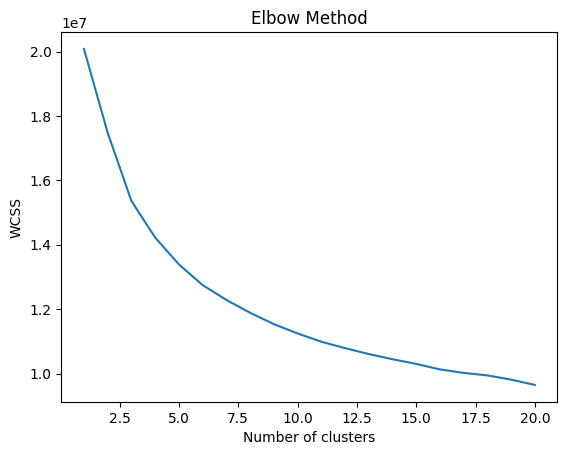

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

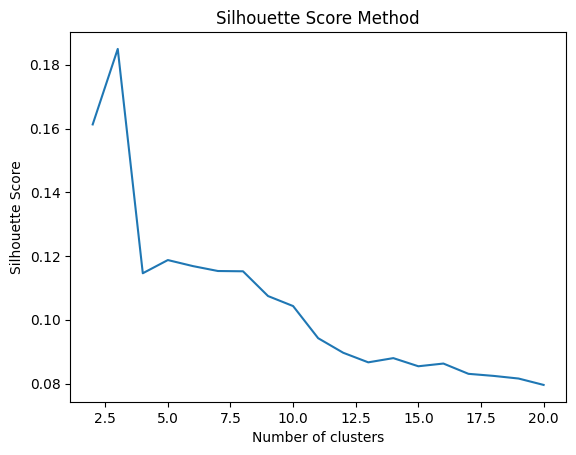

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-17-39d5e6a696f8>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_0['cluster'] = kmeans.fit_predict(class_0.drop(columns=['age_binary', 'filename']))


      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0      0.686275   0.698039   0.698039   0.686275   0.686275   0.682353   
1      0.576471   0.556863   0.549020   0.560784   0.560784   0.556863   
2      0.898039   0.560784   0.250980   0.223529   0.258824   0.203922   
3      0.447059   0.439216   0.439216   0.443137   0.435294   0.427451   
4      0.321569   0.368627   0.372549   0.400000   0.415686   0.329412   
...         ...        ...        ...        ...        ...        ...   
6224   0.466667   0.505882   0.517647   0.478431   0.443137   0.411765   
6225   0.584314   0.596078   0.584314   0.584314   0.592157   0.603922   
6226   0.600000   0.596078   0.596078   0.596078   0.600000   0.603922   
6227   0.266667   0.231373   0.215686   0.352941   0.235294   0.258824   
6228   0.090196   0.105882   0.086275   0.086275   0.090196   0.094118   

      feature_6  feature_7  feature_8  feature_9  ...  landmark_128  \
0      0.643137   0.380392   0.392157   

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
# Separate classes
class_0 = merged_df[merged_df['age_binary'] == 0]
class_1 = merged_df[merged_df['age_binary'] == 1]
n_class_1 = len(class_1)

# Elbow Method
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(class_0.drop(columns=['age_binary', 'filename']))
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silhouette Score
silhouette_scores = []
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(class_0.drop(columns=['age_binary', 'filename']))
    score = silhouette_score(class_0.drop(columns=['age_binary', 'filename']), kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 21), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Choose an optimal number of clusters based on the above methods
optimal_clusters = 10  # Example: based on elbow and silhouette methods

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
class_0['cluster'] = kmeans.fit_predict(class_0.drop(columns=['age_binary', 'filename']))

# Sample from each cluster
sampled_class_0 = pd.DataFrame()
for cluster in range(optimal_clusters):
    cluster_data = class_0[class_0['cluster'] == cluster]
    if len(cluster_data) > n_class_1 / optimal_clusters:
        cluster_sample = cluster_data.sample(n=int(n_class_1 / optimal_clusters), random_state=42)
    else:
        cluster_sample = cluster_data
    sampled_class_0 = pd.concat([sampled_class_0, cluster_sample])

sampled_class_0 = sampled_class_0.drop(columns=['cluster'])
balanced_df = pd.concat([sampled_class_0, class_1])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the balanced DataFrame
print(balanced_df)

In [ ]:
balanced_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,landmark_128,landmark_129,landmark_130,landmark_131,landmark_132,landmark_133,landmark_134,landmark_135,filename,age_binary
0,0.686275,0.698039,0.698039,0.686275,0.686275,0.682353,0.643137,0.380392,0.392157,0.396078,...,63.0,77.0,53.0,77.0,49.0,78.0,45.0,77.0,309262_01M17.JPG,1
1,0.576471,0.556863,0.549020,0.560784,0.560784,0.556863,0.552941,0.545098,0.501961,0.376471,...,61.5,75.0,54.0,75.5,50.0,76.0,46.0,76.0,11533A44.jpg,0
2,0.898039,0.560784,0.250980,0.223529,0.258824,0.203922,0.192157,0.215686,0.176471,0.180392,...,65.5,76.5,55.0,77.5,52.0,78.0,48.5,78.0,00248A05.jpg,1
3,0.447059,0.439216,0.439216,0.443137,0.435294,0.427451,0.443137,0.462745,0.458824,0.454902,...,69.0,79.0,59.0,82.0,54.0,83.0,49.0,83.0,324443_04M19.JPG,0
4,0.321569,0.368627,0.372549,0.400000,0.415686,0.329412,0.254902,0.196078,0.215686,0.309804,...,60.0,80.0,55.0,82.0,51.0,82.5,47.0,82.5,12836A63.jpg,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224,0.466667,0.505882,0.517647,0.478431,0.443137,0.411765,0.431373,0.415686,0.376471,0.345098,...,63.0,78.0,54.0,79.5,50.5,80.0,46.5,79.5,08284A17.jpg,1
6225,0.584314,0.596078,0.584314,0.584314,0.592157,0.603922,0.592157,0.631373,0.549020,0.321569,...,59.0,80.0,53.0,78.0,49.0,78.0,45.0,78.0,310395_01M17.JPG,1
6226,0.600000,0.596078,0.596078,0.596078,0.600000,0.603922,0.596078,0.572549,0.580392,0.576471,...,60.0,77.0,53.0,75.0,49.0,75.0,45.0,75.0,303613_01M17.JPG,1
6227,0.266667,0.231373,0.215686,0.352941,0.235294,0.258824,0.301961,0.298039,0.286275,0.376471,...,65.0,79.0,55.0,79.0,51.0,80.0,46.0,79.0,337252_05M17.JPG,1


In [ ]:
# Save the balanced DataFrame to a new CSV file
balanced_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/Balanced_aam_ages_clustered.csv'
balanced_df.to_csv(balanced_output_path, index=False)

In [ ]:
import pandas as pd

# Path to the features CSV file
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/Balanced_aam_ages_clustered.csv'

# Read the CSV file into a DataFrame
balanced_df1 = pd.read_csv(features_output_path)

# Display the first few rows of the DataFrame
print(balanced_df1)

      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0      0.686275   0.698039   0.698039   0.686275   0.686275   0.682353   
1      0.576471   0.556863   0.549020   0.560784   0.560784   0.556863   
2      0.898039   0.560784   0.250980   0.223529   0.258824   0.203922   
3      0.447059   0.439216   0.439216   0.443137   0.435294   0.427451   
4      0.321569   0.368627   0.372549   0.400000   0.415686   0.329412   
...         ...        ...        ...        ...        ...        ...   
6224   0.466667   0.505882   0.517647   0.478431   0.443137   0.411765   
6225   0.584314   0.596078   0.584314   0.584314   0.592157   0.603922   
6226   0.600000   0.596078   0.596078   0.596078   0.600000   0.603922   
6227   0.266667   0.231373   0.215686   0.352941   0.235294   0.258824   
6228   0.090196   0.105882   0.086275   0.086275   0.090196   0.094118   

      feature_6  feature_7  feature_8  feature_9  ...  landmark_128  \
0      0.643137   0.380392   0.392157   

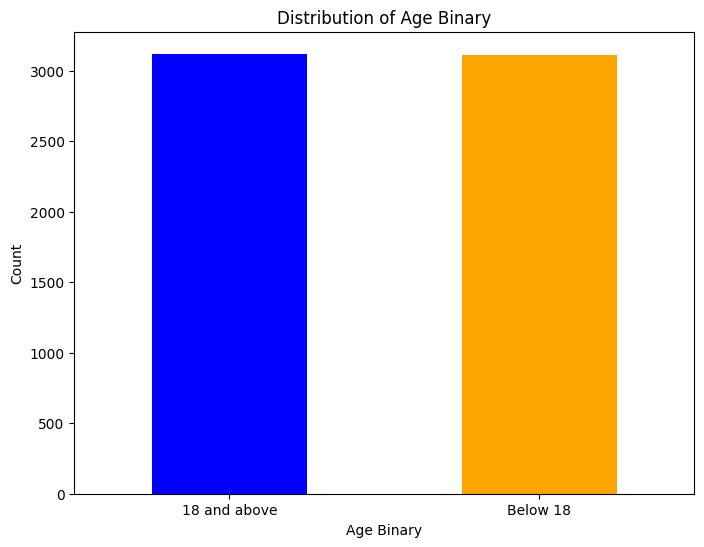

In [ ]:
# Plot the distribution of age_binary
plt.figure(figsize=(8, 6))
balanced_df1['age_binary'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Age Binary')
plt.xlabel('Age Binary')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['18 and above', 'Below 18'], rotation=0)
plt.show()

balanced dataset with 10138 features

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
# Prepare the data
X = balanced_df1.drop(columns=['filename', 'age_binary'])  # Features
y = balanced_df1['age_binary']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (Random Forest in this case)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       625
           1       0.69      0.76      0.72       621

    accuracy                           0.71      1246
   macro avg       0.71      0.71      0.71      1246
weighted avg       0.71      0.71      0.71      1246



Applying chisquare to df

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from google.colab import drive
# Prepare to store Chi-Square results
chi2_results = []
p_values = []
features = []

# Perform Chi-Square test for each feature across age_binary groups
for i in range(balanced_df1.shape[1] - 2):  # Exclude 'filename' and 'age_binary' columns
    feature_column = balanced_df1.columns[i]
    contingency_table = pd.crosstab(balanced_df1['age_binary'], balanced_df1[feature_column])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append(chi2)
    p_values.append(p)
    features.append(feature_column)

# Create a DataFrame for Chi-Square results
results_df_chi = pd.DataFrame({
    'Feature': features,
    'Chi2': chi2_results,
    'p-value': p_values
})

# Display the results
from IPython.display import display
display(results_df_chi)

print(results_df_chi)

,Feature,Chi2,p-value
0,feature_0,436.747150,1.031814e-11
1,feature_1,405.563902,5.772126e-09
2,feature_2,436.799425,7.732783e-12
3,feature_3,415.738834,7.887032e-10
4,feature_4,366.088400,5.048409e-06
...,...,...,...
10131,landmark_131,297.744307,2.401038e-37
10132,landmark_132,228.673589,2.301539e-23
10133,landmark_133,298.470479,2.761670e-38
10134,landmark_134,204.368618,1.475878e-20


            Feature        Chi2       p-value
0         feature_0  436.747150  1.031814e-11
1         feature_1  405.563902  5.772126e-09
2         feature_2  436.799425  7.732783e-12
3         feature_3  415.738834  7.887032e-10
4         feature_4  366.088400  5.048409e-06
...             ...         ...           ...
10131  landmark_131  297.744307  2.401038e-37
10132  landmark_132  228.673589  2.301539e-23
10133  landmark_133  298.470479  2.761670e-38
10134  landmark_134  204.368618  1.475878e-20
10135  landmark_135  334.178156  6.075041e-45

[10136 rows x 3 columns]


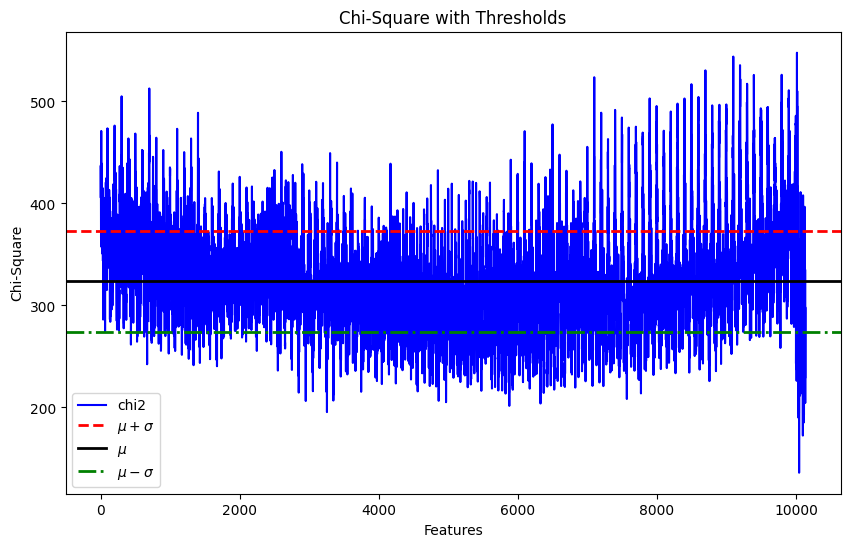

,feature_0,feature_1,feature_2,feature_3,feature_5,feature_6,feature_7,feature_10,feature_12,feature_13,...,landmark_118,landmark_123,landmark_124,landmark_125,landmark_126,landmark_127,landmark_130,landmark_132,landmark_134,age_binary
0,0.686275,0.698039,0.698039,0.686275,0.682353,0.643137,0.380392,0.384314,0.396078,0.415686,...,38.0,76.0,49.0,77.0,53.0,76.0,53.0,49.0,45.0,1
1,0.576471,0.556863,0.549020,0.560784,0.556863,0.552941,0.545098,0.176471,0.086275,0.149020,...,41.0,73.5,49.5,74.0,54.0,73.5,54.0,50.0,46.0,0
2,0.898039,0.560784,0.250980,0.223529,0.203922,0.192157,0.215686,0.133333,0.192157,0.152941,...,42.5,78.0,52.0,78.5,55.0,78.0,55.0,52.0,48.5,1
3,0.447059,0.439216,0.439216,0.443137,0.427451,0.443137,0.462745,0.447059,0.431373,0.447059,...,44.0,77.0,53.0,77.0,58.0,76.0,59.0,54.0,49.0,0
4,0.321569,0.368627,0.372549,0.400000,0.329412,0.254902,0.196078,0.411765,0.443137,0.454902,...,41.0,78.0,51.5,78.0,55.5,77.5,55.0,51.0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224,0.466667,0.505882,0.517647,0.478431,0.411765,0.431373,0.415686,0.321569,0.262745,0.247059,...,42.0,80.0,50.0,80.5,53.5,80.0,54.0,50.5,46.5,1
6225,0.584314,0.596078,0.584314,0.584314,0.603922,0.592157,0.631373,0.172549,0.152941,0.164706,...,39.0,78.0,49.0,78.0,53.0,78.0,53.0,49.0,45.0,1
6226,0.600000,0.596078,0.596078,0.596078,0.603922,0.596078,0.572549,0.592157,0.615686,0.611765,...,39.0,74.0,49.0,75.0,53.0,74.0,53.0,49.0,45.0,1
6227,0.266667,0.231373,0.215686,0.352941,0.258824,0.301961,0.298039,0.333333,0.223529,0.192157,...,39.0,79.0,51.0,80.0,55.0,79.0,55.0,51.0,46.0,1


In [ ]:
# Calculate mean and standard deviation of Chi-Square values
mean_chi2 = results_df_chi['Chi2'].mean()
std_chi2 = results_df_chi['Chi2'].std()

# Define thresholds
threshold1 = mean_chi2 + std_chi2
threshold2 = mean_chi2
threshold3 = mean_chi2 - std_chi2

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(results_df_chi['Chi2'].values, label='chi2', color='blue')

# Add threshold lines
plt.axhline(y=threshold1, color='red', linestyle='--', linewidth=2, label='$\mu + \sigma$')
plt.axhline(y=threshold2, color='black', linestyle='-', linewidth=2, label='$\mu$')
plt.axhline(y=threshold3, color='green', linestyle='-.', linewidth=2, label='$\mu - \sigma$')

# Add labels and legend
plt.xlabel('Features')
plt.ylabel('Chi-Square')
plt.title('Chi-Square with Thresholds')
plt.legend()

# Show the plot
plt.show()

# Filter features based on thresholds
filtered_features = results_df_chi[(results_df_chi['Chi2'] > threshold1) | (results_df_chi['Chi2'] < threshold3)]['Feature']

# Create a new DataFrame with only the filtered features
filtered_feature_columns = filtered_features.tolist() + ['age_binary']
filtered_df = balanced_df1[filtered_feature_columns]

# Display the filtered DataFrame
display(filtered_df)

In [ ]:
filtered_df

,feature_0,feature_1,feature_2,feature_3,feature_5,feature_6,feature_7,feature_10,feature_12,feature_13,...,landmark_118,landmark_123,landmark_124,landmark_125,landmark_126,landmark_127,landmark_130,landmark_132,landmark_134,age_binary
0,0.686275,0.698039,0.698039,0.686275,0.682353,0.643137,0.380392,0.384314,0.396078,0.415686,...,38.0,76.0,49.0,77.0,53.0,76.0,53.0,49.0,45.0,1
1,0.576471,0.556863,0.549020,0.560784,0.556863,0.552941,0.545098,0.176471,0.086275,0.149020,...,41.0,73.5,49.5,74.0,54.0,73.5,54.0,50.0,46.0,0
2,0.898039,0.560784,0.250980,0.223529,0.203922,0.192157,0.215686,0.133333,0.192157,0.152941,...,42.5,78.0,52.0,78.5,55.0,78.0,55.0,52.0,48.5,1
3,0.447059,0.439216,0.439216,0.443137,0.427451,0.443137,0.462745,0.447059,0.431373,0.447059,...,44.0,77.0,53.0,77.0,58.0,76.0,59.0,54.0,49.0,0
4,0.321569,0.368627,0.372549,0.400000,0.329412,0.254902,0.196078,0.411765,0.443137,0.454902,...,41.0,78.0,51.5,78.0,55.5,77.5,55.0,51.0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224,0.466667,0.505882,0.517647,0.478431,0.411765,0.431373,0.415686,0.321569,0.262745,0.247059,...,42.0,80.0,50.0,80.5,53.5,80.0,54.0,50.5,46.5,1
6225,0.584314,0.596078,0.584314,0.584314,0.603922,0.592157,0.631373,0.172549,0.152941,0.164706,...,39.0,78.0,49.0,78.0,53.0,78.0,53.0,49.0,45.0,1
6226,0.600000,0.596078,0.596078,0.596078,0.603922,0.596078,0.572549,0.592157,0.615686,0.611765,...,39.0,74.0,49.0,75.0,53.0,74.0,53.0,49.0,45.0,1
6227,0.266667,0.231373,0.215686,0.352941,0.258824,0.301961,0.298039,0.333333,0.223529,0.192157,...,39.0,79.0,51.0,80.0,55.0,79.0,55.0,51.0,46.0,1


In [ ]:
# Save the filtered DataFrame to a new CSV file
filtered_features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/Chi_balanced_aam_features.csv'
filtered_df.to_csv(filtered_features_output_path, index=False)

Final Dataframe of chi-square selected features with age column

In [ ]:
import pandas as pd

# Path to the features CSV file
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/Chi_balanced_aam_features.csv'

# Read the CSV file into a DataFrame
balanced_df_chi1 = pd.read_csv(features_output_path)

# Display the first few rows of the DataFrame
print(balanced_df_chi1)

      feature_0  feature_1  feature_2  feature_3  feature_5  feature_6  \
0      0.686275   0.698039   0.698039   0.686275   0.682353   0.643137   
1      0.576471   0.556863   0.549020   0.560784   0.556863   0.552941   
2      0.898039   0.560784   0.250980   0.223529   0.203922   0.192157   
3      0.447059   0.439216   0.439216   0.443137   0.427451   0.443137   
4      0.321569   0.368627   0.372549   0.400000   0.329412   0.254902   
...         ...        ...        ...        ...        ...        ...   
6224   0.466667   0.505882   0.517647   0.478431   0.411765   0.431373   
6225   0.584314   0.596078   0.584314   0.584314   0.603922   0.592157   
6226   0.600000   0.596078   0.596078   0.596078   0.603922   0.596078   
6227   0.266667   0.231373   0.215686   0.352941   0.258824   0.301961   
6228   0.090196   0.105882   0.086275   0.086275   0.094118   0.090196   

      feature_7  feature_10  feature_12  feature_13  ...  landmark_118  \
0      0.380392    0.384314    0.3960

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming lbp_df is already created and has the 'age_binary' column as the label
# Sample lbp_df for demonstration, replace with actual data
# lbp_df = pd.read_csv('your_data.csv')  # If your data is in a CSV file

# Separate features and labels
X = balanced_df_chi1.drop(columns=['age_binary'])  # Features
y = balanced_df_chi1['age_binary']  # Label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.7070626003210273
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       625
           1       0.69      0.75      0.72       621

    accuracy                           0.71      1246
   macro avg       0.71      0.71      0.71      1246
weighted avg       0.71      0.71      0.71      1246



In [ ]:
balanced_df1

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,landmark_128,landmark_129,landmark_130,landmark_131,landmark_132,landmark_133,landmark_134,landmark_135,filename,age_binary
0,0.686275,0.698039,0.698039,0.686275,0.686275,0.682353,0.643137,0.380392,0.392157,0.396078,...,63.0,77.0,53.0,77.0,49.0,78.0,45.0,77.0,309262_01M17.JPG,1
1,0.576471,0.556863,0.549020,0.560784,0.560784,0.556863,0.552941,0.545098,0.501961,0.376471,...,61.5,75.0,54.0,75.5,50.0,76.0,46.0,76.0,11533A44.jpg,0
2,0.898039,0.560784,0.250980,0.223529,0.258824,0.203922,0.192157,0.215686,0.176471,0.180392,...,65.5,76.5,55.0,77.5,52.0,78.0,48.5,78.0,00248A05.jpg,1
3,0.447059,0.439216,0.439216,0.443137,0.435294,0.427451,0.443137,0.462745,0.458824,0.454902,...,69.0,79.0,59.0,82.0,54.0,83.0,49.0,83.0,324443_04M19.JPG,0
4,0.321569,0.368627,0.372549,0.400000,0.415686,0.329412,0.254902,0.196078,0.215686,0.309804,...,60.0,80.0,55.0,82.0,51.0,82.5,47.0,82.5,12836A63.jpg,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224,0.466667,0.505882,0.517647,0.478431,0.443137,0.411765,0.431373,0.415686,0.376471,0.345098,...,63.0,78.0,54.0,79.5,50.5,80.0,46.5,79.5,08284A17.jpg,1
6225,0.584314,0.596078,0.584314,0.584314,0.592157,0.603922,0.592157,0.631373,0.549020,0.321569,...,59.0,80.0,53.0,78.0,49.0,78.0,45.0,78.0,310395_01M17.JPG,1
6226,0.600000,0.596078,0.596078,0.596078,0.600000,0.603922,0.596078,0.572549,0.580392,0.576471,...,60.0,77.0,53.0,75.0,49.0,75.0,45.0,75.0,303613_01M17.JPG,1
6227,0.266667,0.231373,0.215686,0.352941,0.235294,0.258824,0.301961,0.298039,0.286275,0.376471,...,65.0,79.0,55.0,79.0,51.0,80.0,46.0,79.0,337252_05M17.JPG,1


Applying Annova

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif
from google.colab import drive
# Function to compute ANOVA F-test scores in batches
def compute_anova_in_batches(features, labels, batch_size=100):
    n_features = features.shape[1]
    anova_scores = np.zeros(n_features)

    for start in range(0, n_features, batch_size):
        end = min(start + batch_size, n_features)
        _, p_values = f_classif(features.iloc[:, start:end], labels)
        anova_scores[start:end] = -np.log10(p_values)  # Using -log10(p-values) for better interpretation

    return anova_scores

# Separate features and labels
features = balanced_df1.drop(columns=['age_binary', 'filename'])
labels = balanced_df1['age_binary']

# Compute ANOVA F-test scores in batches
batch_size = 100  # Adjust the batch size as needed
anova_scores = compute_anova_in_batches(features, labels, batch_size)

# Create a DataFrame to hold scores
scores_df = pd.DataFrame({
    'Feature': features.columns,
    'Score': anova_scores
})

# Sort and select top features based on a threshold
scores_df = scores_df.sort_values(by='Score', ascending=False)
mean_score = scores_df['Score'].mean()
std_score = scores_df['Score'].std()
threshold = mean_score + std_score

selected_features = scores_df[scores_df['Score'] >= threshold]['Feature'].tolist()
selected_df = balanced_df1[selected_features + ['age_binary']]

# Display the selected DataFrame using standard display methods
from IPython.display import display
display(selected_df)
print(selected_df)

,landmark_15,landmark_17,landmark_101,landmark_13,landmark_95,landmark_103,landmark_105,landmark_19,landmark_93,landmark_85,...,feature_4253,feature_9361,feature_9961,feature_2631,feature_2699,feature_2535,feature_1296,feature_5363,feature_6395,age_binary
0,101.0,102.0,70.0,97.0,42.0,71.0,70.0,101.0,42.0,41.0,...,0.964706,0.835294,0.584314,0.952941,0.709804,0.996078,0.686275,0.980392,0.643137,1
1,100.0,100.5,70.5,96.5,40.5,71.5,70.5,99.5,40.5,40.0,...,0.839216,0.878431,0.674510,0.458824,0.568627,0.611765,0.309804,0.980392,0.882353,0
2,99.0,100.5,74.5,95.0,41.0,75.5,74.5,99.5,40.5,40.0,...,0.803922,0.772549,0.666667,0.450980,0.196078,0.600000,0.196078,0.800000,0.462745,1
3,103.0,103.0,72.0,100.0,41.0,72.0,71.0,102.0,40.0,40.0,...,0.584314,0.243137,0.396078,0.545098,0.450980,0.584314,0.450980,0.596078,0.388235,0
4,100.5,101.0,74.0,96.5,39.0,75.0,74.0,99.0,38.5,39.0,...,0.537255,0.309804,0.235294,0.560784,0.219608,0.705882,0.172549,0.580392,0.325490,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224,99.0,100.5,77.0,91.5,43.0,77.5,76.5,99.0,43.0,42.0,...,0.203922,0.752941,0.501961,0.721569,0.858824,0.760784,0.258824,0.756863,0.278431,1
6225,101.0,102.0,72.0,97.0,45.0,74.0,73.0,102.0,45.0,43.0,...,0.980392,0.564706,0.435294,0.878431,0.596078,0.996078,0.564706,0.992157,0.619608,1
6226,101.0,101.0,69.0,98.0,44.0,70.0,69.0,101.0,44.0,42.0,...,0.964706,0.670588,0.200000,0.996078,0.596078,0.996078,0.584314,0.996078,0.584314,1
6227,102.0,103.0,74.0,99.0,41.0,75.0,74.0,102.0,41.0,41.0,...,0.654902,0.403922,0.262745,0.478431,0.156863,0.890196,0.203922,0.862745,0.113725,1


      landmark_15  landmark_17  landmark_101  landmark_13  landmark_95  \
0           101.0        102.0          70.0         97.0         42.0   
1           100.0        100.5          70.5         96.5         40.5   
2            99.0        100.5          74.5         95.0         41.0   
3           103.0        103.0          72.0        100.0         41.0   
4           100.5        101.0          74.0         96.5         39.0   
...           ...          ...           ...          ...          ...   
6224         99.0        100.5          77.0         91.5         43.0   
6225        101.0        102.0          72.0         97.0         45.0   
6226        101.0        101.0          69.0         98.0         44.0   
6227        102.0        103.0          74.0         99.0         41.0   
6228        100.5        102.0          76.5         94.5         41.0   

      landmark_103  landmark_105  landmark_19  landmark_93  landmark_85  ...  \
0             71.0          70.

In [ ]:
selected_df

,landmark_15,landmark_17,landmark_101,landmark_13,landmark_95,landmark_103,landmark_105,landmark_19,landmark_93,landmark_85,...,feature_4253,feature_9361,feature_9961,feature_2631,feature_2699,feature_2535,feature_1296,feature_5363,feature_6395,age_binary
0,101.0,102.0,70.0,97.0,42.0,71.0,70.0,101.0,42.0,41.0,...,0.964706,0.835294,0.584314,0.952941,0.709804,0.996078,0.686275,0.980392,0.643137,1
1,100.0,100.5,70.5,96.5,40.5,71.5,70.5,99.5,40.5,40.0,...,0.839216,0.878431,0.674510,0.458824,0.568627,0.611765,0.309804,0.980392,0.882353,0
2,99.0,100.5,74.5,95.0,41.0,75.5,74.5,99.5,40.5,40.0,...,0.803922,0.772549,0.666667,0.450980,0.196078,0.600000,0.196078,0.800000,0.462745,1
3,103.0,103.0,72.0,100.0,41.0,72.0,71.0,102.0,40.0,40.0,...,0.584314,0.243137,0.396078,0.545098,0.450980,0.584314,0.450980,0.596078,0.388235,0
4,100.5,101.0,74.0,96.5,39.0,75.0,74.0,99.0,38.5,39.0,...,0.537255,0.309804,0.235294,0.560784,0.219608,0.705882,0.172549,0.580392,0.325490,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224,99.0,100.5,77.0,91.5,43.0,77.5,76.5,99.0,43.0,42.0,...,0.203922,0.752941,0.501961,0.721569,0.858824,0.760784,0.258824,0.756863,0.278431,1
6225,101.0,102.0,72.0,97.0,45.0,74.0,73.0,102.0,45.0,43.0,...,0.980392,0.564706,0.435294,0.878431,0.596078,0.996078,0.564706,0.992157,0.619608,1
6226,101.0,101.0,69.0,98.0,44.0,70.0,69.0,101.0,44.0,42.0,...,0.964706,0.670588,0.200000,0.996078,0.596078,0.996078,0.584314,0.996078,0.584314,1
6227,102.0,103.0,74.0,99.0,41.0,75.0,74.0,102.0,41.0,41.0,...,0.654902,0.403922,0.262745,0.478431,0.156863,0.890196,0.203922,0.862745,0.113725,1


In [ ]:
# Save the filtered DataFrame to a new CSV file
filtered_features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/Annova_balanced_aam_features.csv'
selected_df.to_csv(filtered_features_output_path, index=False)

Annova applied to balanced dataset final

In [ ]:
import pandas as pd

# Path to the features CSV file
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/Annova_balanced_aam_features.csv'

# Read the CSV file into a DataFrame
balanced_df_annova1 = pd.read_csv(features_output_path)

# Display the first few rows of the DataFrame
print(balanced_df_annova1)

      landmark_15  landmark_17  landmark_101  landmark_13  landmark_95  \
0           101.0        102.0          70.0         97.0         42.0   
1           100.0        100.5          70.5         96.5         40.5   
2            99.0        100.5          74.5         95.0         41.0   
3           103.0        103.0          72.0        100.0         41.0   
4           100.5        101.0          74.0         96.5         39.0   
...           ...          ...           ...          ...          ...   
6224         99.0        100.5          77.0         91.5         43.0   
6225        101.0        102.0          72.0         97.0         45.0   
6226        101.0        101.0          69.0         98.0         44.0   
6227        102.0        103.0          74.0         99.0         41.0   
6228        100.5        102.0          76.5         94.5         41.0   

      landmark_103  landmark_105  landmark_19  landmark_93  landmark_85  ...  \
0             71.0          70.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming lbp_df is already created and has the 'age_binary' column as the label
# Sample lbp_df for demonstration, replace with actual data
# lbp_df = pd.read_csv('your_data.csv')  # If your data is in a CSV file

# Separate features and labels
X = balanced_df_annova1.drop(columns=['age_binary'])  # Features
y = balanced_df_annova1['age_binary']  # Label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.7134831460674157
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       625
           1       0.69      0.77      0.73       621

    accuracy                           0.71      1246
   macro avg       0.72      0.71      0.71      1246
weighted avg       0.72      0.71      0.71      1246



applying info score to balanced df of aam

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from google.colab import drive


# Separate features and labels
features = balanced_df1.drop(columns=['age_binary', 'filename'])
labels = balanced_df1['age_binary']

# Compute Mutual Information scores
mi_scores = mutual_info_classif(features, labels)

# Create a DataFrame to hold scores
mi_scores_df = pd.DataFrame({
    'Feature': features.columns,
    'Score': mi_scores
})

# Sort and select top features based on a threshold
mi_scores_df = mi_scores_df.sort_values(by='Score', ascending=False)
mean_score = mi_scores_df['Score'].mean()
std_score = mi_scores_df['Score'].std()
threshold = mean_score + std_score

selected_features = mi_scores_df[mi_scores_df['Score'] >= threshold]['Feature'].tolist()
selected_df = balanced_df1[selected_features + ['age_binary']]

# Display the selected DataFrame using standard display methods
from IPython.display import display
display(selected_df)
print(selected_df)

,landmark_19,landmark_21,landmark_123,landmark_13,landmark_15,landmark_29,landmark_103,feature_1398,landmark_69,feature_6600,...,feature_907,feature_8804,feature_7160,feature_2999,feature_488,feature_7479,feature_1555,feature_3032,feature_9116,age_binary
0,101.0,97.0,76.0,97.0,101.0,60.0,71.0,0.694118,62.0,0.662745,...,0.333333,0.541176,0.878431,0.717647,0.329412,0.623529,0.984314,0.321569,0.619608,1
1,99.5,95.5,73.5,96.5,100.0,64.5,71.5,0.607843,61.5,0.552941,...,0.156863,0.603922,0.898039,0.580392,0.141176,0.913725,0.949020,0.835294,0.576471,0
2,99.5,95.0,78.0,95.0,99.0,61.5,75.5,0.180392,64.0,0.388235,...,0.188235,0.952941,0.792157,0.200000,0.149020,0.741176,0.290196,0.721569,0.960784,1
3,102.0,97.0,77.0,100.0,103.0,58.0,72.0,0.462745,62.0,0.419608,...,0.427451,0.380392,0.494118,0.450980,0.345098,0.466667,0.615686,0.462745,0.372549,0
4,99.0,93.5,78.0,96.5,100.5,56.0,75.0,0.172549,65.5,0.592157,...,0.509804,0.035294,0.396078,0.262745,0.149020,0.368627,0.556863,0.329412,0.380392,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224,99.0,92.5,80.0,91.5,99.0,56.5,77.5,0.568627,69.5,0.215686,...,0.290196,0.286275,0.752941,0.823529,0.243137,0.694118,0.784314,0.372549,0.105882,1
6225,102.0,100.0,78.0,97.0,101.0,66.0,74.0,0.572549,63.0,0.572549,...,0.262745,0.537255,0.803922,0.607843,0.545098,0.600000,0.996078,0.301961,0.400000,1
6226,101.0,98.0,74.0,98.0,101.0,66.0,70.0,0.592157,61.0,0.525490,...,0.576471,0.447059,0.862745,0.580392,0.572549,0.686275,1.000000,0.380392,0.384314,1
6227,102.0,98.0,79.0,99.0,102.0,61.0,75.0,0.180392,64.0,0.415686,...,0.278431,0.090196,0.439216,0.231373,0.200000,0.411765,0.282353,0.176471,0.290196,1


      landmark_19  landmark_21  landmark_123  landmark_13  landmark_15  \
0           101.0         97.0          76.0         97.0        101.0   
1            99.5         95.5          73.5         96.5        100.0   
2            99.5         95.0          78.0         95.0         99.0   
3           102.0         97.0          77.0        100.0        103.0   
4            99.0         93.5          78.0         96.5        100.5   
...           ...          ...           ...          ...          ...   
6224         99.0         92.5          80.0         91.5         99.0   
6225        102.0        100.0          78.0         97.0        101.0   
6226        101.0         98.0          74.0         98.0        101.0   
6227        102.0         98.0          79.0         99.0        102.0   
6228        101.5         97.5          80.5         94.5        100.5   

      landmark_29  landmark_103  feature_1398  landmark_69  feature_6600  ...  \
0            60.0          71.

In [ ]:
selected_df

,landmark_19,landmark_21,landmark_123,landmark_13,landmark_15,landmark_29,landmark_103,feature_1398,landmark_69,feature_6600,...,feature_907,feature_8804,feature_7160,feature_2999,feature_488,feature_7479,feature_1555,feature_3032,feature_9116,age_binary
0,101.0,97.0,76.0,97.0,101.0,60.0,71.0,0.694118,62.0,0.662745,...,0.333333,0.541176,0.878431,0.717647,0.329412,0.623529,0.984314,0.321569,0.619608,1
1,99.5,95.5,73.5,96.5,100.0,64.5,71.5,0.607843,61.5,0.552941,...,0.156863,0.603922,0.898039,0.580392,0.141176,0.913725,0.949020,0.835294,0.576471,0
2,99.5,95.0,78.0,95.0,99.0,61.5,75.5,0.180392,64.0,0.388235,...,0.188235,0.952941,0.792157,0.200000,0.149020,0.741176,0.290196,0.721569,0.960784,1
3,102.0,97.0,77.0,100.0,103.0,58.0,72.0,0.462745,62.0,0.419608,...,0.427451,0.380392,0.494118,0.450980,0.345098,0.466667,0.615686,0.462745,0.372549,0
4,99.0,93.5,78.0,96.5,100.5,56.0,75.0,0.172549,65.5,0.592157,...,0.509804,0.035294,0.396078,0.262745,0.149020,0.368627,0.556863,0.329412,0.380392,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224,99.0,92.5,80.0,91.5,99.0,56.5,77.5,0.568627,69.5,0.215686,...,0.290196,0.286275,0.752941,0.823529,0.243137,0.694118,0.784314,0.372549,0.105882,1
6225,102.0,100.0,78.0,97.0,101.0,66.0,74.0,0.572549,63.0,0.572549,...,0.262745,0.537255,0.803922,0.607843,0.545098,0.600000,0.996078,0.301961,0.400000,1
6226,101.0,98.0,74.0,98.0,101.0,66.0,70.0,0.592157,61.0,0.525490,...,0.576471,0.447059,0.862745,0.580392,0.572549,0.686275,1.000000,0.380392,0.384314,1
6227,102.0,98.0,79.0,99.0,102.0,61.0,75.0,0.180392,64.0,0.415686,...,0.278431,0.090196,0.439216,0.231373,0.200000,0.411765,0.282353,0.176471,0.290196,1


In [ ]:
# Save the filtered DataFrame to a new CSV file
filtered_features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/Infoscore_balanced_aam_features.csv'
selected_df.to_csv(filtered_features_output_path, index=False)

final infoscore selected df

In [ ]:
import pandas as pd

# Path to the features CSV file
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/Infoscore_balanced_aam_features.csv'

# Read the CSV file into a DataFrame
balanced_df_infoscore1 = pd.read_csv(features_output_path)

# Display the first few rows of the DataFrame
print(balanced_df_infoscore1)

      landmark_19  landmark_21  landmark_123  landmark_13  landmark_15  \
0           101.0         97.0          76.0         97.0        101.0   
1            99.5         95.5          73.5         96.5        100.0   
2            99.5         95.0          78.0         95.0         99.0   
3           102.0         97.0          77.0        100.0        103.0   
4            99.0         93.5          78.0         96.5        100.5   
...           ...          ...           ...          ...          ...   
6224         99.0         92.5          80.0         91.5         99.0   
6225        102.0        100.0          78.0         97.0        101.0   
6226        101.0         98.0          74.0         98.0        101.0   
6227        102.0         98.0          79.0         99.0        102.0   
6228        101.5         97.5          80.5         94.5        100.5   

      landmark_29  landmark_103  feature_1398  landmark_69  feature_6600  ...  \
0            60.0          71.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming lbp_df is already created and has the 'age_binary' column as the label
# Sample lbp_df for demonstration, replace with actual data
# lbp_df = pd.read_csv('your_data.csv')  # If your data is in a CSV file

# Separate features and labels
X = balanced_df_infoscore1.drop(columns=['age_binary'])  # Features
y = balanced_df_infoscore1['age_binary']  # Label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.6982343499197432
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       625
           1       0.68      0.74      0.71       621

    accuracy                           0.70      1246
   macro avg       0.70      0.70      0.70      1246
weighted avg       0.70      0.70      0.70      1246



Intersection of features

In [ ]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Load the three DataFrames
anova_df_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/Annova_balanced_aam_features.csv'
chi_df_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/Chi_balanced_aam_features.csv'
mi_df_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/Infoscore_balanced_aam_features.csv'

anova_df = pd.read_csv(anova_df_path)
chi_df = pd.read_csv(chi_df_path)
mi_df = pd.read_csv(mi_df_path)

# Get the sets of features
anova_features = set(anova_df.columns) - {'age_binary'}
chi_features = set(chi_df.columns) - {'age_binary'}
mi_features = set(mi_df.columns) - {'age_binary'}

# Find the intersection of the features
common_features = anova_features & chi_features & mi_features

# Create a new DataFrame with the intersecting features and 'age_binary' column
common_features_df = balanced_df1[list(common_features) + ['age_binary']]

# Display the new DataFrame
from IPython.display import display
display(common_features_df)
print(common_features_df)

# Save the new DataFrame to a CSV file
common_features_df_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/common_features.csv'
common_features_df.to_csv(common_features_df_path, index=False)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,feature_9594,feature_8792,feature_9757,feature_9565,feature_8897,feature_9293,feature_8993,feature_7293,feature_9190,feature_8790,...,feature_8194,feature_5556,feature_4652,feature_9790,feature_7399,feature_699,feature_2761,feature_8688,feature_2372,age_binary
0,0.494118,0.517647,0.705882,0.600000,0.517647,0.490196,0.509804,0.607843,0.494118,0.513725,...,0.541176,0.984314,0.996078,0.494118,0.596078,0.674510,0.972549,0.513725,0.992157,1
1,0.623529,0.592157,0.827451,0.815686,0.576471,0.607843,0.588235,0.811765,0.592157,0.600000,...,0.592157,0.929412,0.866667,0.439216,0.615686,0.627451,0.423529,0.588235,0.815686,0
2,0.843137,0.611765,0.717647,0.701961,0.788235,0.800000,0.807843,0.396078,0.780392,0.525490,...,0.196078,0.815686,0.792157,0.811765,0.227451,0.192157,0.474510,0.380392,0.419608,1
3,0.439216,0.384314,0.298039,0.611765,0.439216,0.447059,0.435294,0.368627,0.423529,0.392157,...,0.447059,0.666667,0.756863,0.431373,0.435294,0.458824,0.266667,0.207843,0.654902,0
4,0.223529,0.329412,0.313725,0.380392,0.305882,0.286275,0.333333,0.341176,0.278431,0.337255,...,0.360784,0.607843,0.647059,0.286275,0.372549,0.235294,0.435294,0.333333,0.286275,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224,0.133333,0.086275,0.694118,0.647059,0.180392,0.082353,0.098039,0.117647,0.082353,0.082353,...,0.105882,0.486275,0.443137,0.078431,0.200000,0.800000,0.650980,0.082353,0.768627,1
6225,0.607843,0.615686,0.564706,0.537255,0.607843,0.611765,0.607843,0.627451,0.627451,0.627451,...,0.627451,0.913725,0.996078,0.592157,0.627451,0.568627,0.996078,0.627451,0.949020,1
6226,0.419608,0.407843,0.317647,0.239216,0.407843,0.407843,0.392157,0.478431,0.415686,0.419608,...,0.415686,0.937255,0.996078,0.403922,0.454902,0.580392,0.996078,0.407843,0.956863,1
6227,0.858824,0.654902,0.572549,0.258824,0.152941,0.815686,0.745098,0.141176,0.768627,0.152941,...,0.137255,0.898039,0.807843,0.803922,0.125490,0.098039,0.290196,0.098039,0.415686,1


      feature_9594  feature_8792  feature_9757  feature_9565  feature_8897  \
0         0.494118      0.517647      0.705882      0.600000      0.517647   
1         0.623529      0.592157      0.827451      0.815686      0.576471   
2         0.843137      0.611765      0.717647      0.701961      0.788235   
3         0.439216      0.384314      0.298039      0.611765      0.439216   
4         0.223529      0.329412      0.313725      0.380392      0.305882   
...            ...           ...           ...           ...           ...   
6224      0.133333      0.086275      0.694118      0.647059      0.180392   
6225      0.607843      0.615686      0.564706      0.537255      0.607843   
6226      0.419608      0.407843      0.317647      0.239216      0.407843   
6227      0.858824      0.654902      0.572549      0.258824      0.152941   
6228      0.121569      0.101961      0.603922      0.439216      0.117647   

      feature_9293  feature_8993  feature_7293  feature_9190  f

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming lbp_df is already created and has the 'age_binary' column as the label
# Sample lbp_df for demonstration, replace with actual data
# lbp_df = pd.read_csv('your_data.csv')  # If your data is in a CSV file

# Separate features and labels
X = common_features_df.drop(columns=['age_binary'])  # Features
y = common_features_df['age_binary']  # Label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.7046548956661316
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       625
           1       0.68      0.76      0.72       621

    accuracy                           0.70      1246
   macro avg       0.71      0.70      0.70      1246
weighted avg       0.71      0.70      0.70      1246



Applying PCA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from google.colab import drive
# Separate features and target variable
features = balanced_df1.drop(columns=['age_binary', 'filename'])
target = balanced_df1['age_binary']

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA()
features_pca = pca.fit_transform(features_scaled)

# Determine the number of components to explain 95% of the variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1

print(f'Number of components to explain 95% variance: {n_components}')

# Select the top principal components
features_pca_selected = features_pca[:, :n_components]

# Create a new DataFrame with the selected principal components and the target variable
pca_columns = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(features_pca_selected, columns=pca_columns)
pca_df['age_binary'] = target.values

# Display the new DataFrame
from IPython.display import display
display(pca_df)
print(pca_df)

Number of components to explain 95% variance: 308


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC300,PC301,PC302,PC303,PC304,PC305,PC306,PC307,PC308,age_binary
0,-94.786796,-13.400989,-15.621763,-9.147469,-15.015189,-2.779012,11.115849,-6.578504,-10.767660,-4.778379,...,0.381126,0.544585,-1.426223,-0.748764,-0.774889,-0.574063,-0.221935,-1.182400,-1.457369,1
1,-114.104416,15.608662,17.394998,17.448668,-16.402836,2.066298,-21.134766,4.879757,-8.743730,-0.192132,...,0.553156,-0.785812,0.022719,-1.003075,1.584477,-0.205889,0.641405,-0.883463,-0.210456,0
2,-14.018874,34.436672,71.280926,13.385822,-22.428600,-0.287726,-3.305508,19.583754,20.910555,-14.986175,...,-0.503481,1.025495,-0.794700,0.779802,-0.294007,-0.689079,-0.057018,-0.564195,0.583492,1
3,70.974258,-10.903955,-24.812411,12.020256,-2.991390,22.627877,14.140260,3.678798,-3.553426,-10.694290,...,0.967785,1.052672,-1.483519,0.566021,-0.718785,0.461763,-2.821206,0.542596,0.800531,0
4,51.717229,-6.530642,-4.826910,-50.426563,14.938970,-1.823558,-4.653366,22.227769,-15.325942,4.313662,...,-0.053932,-0.192676,1.018914,1.251036,-0.744461,1.598062,-0.613155,0.910184,0.463461,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224,-12.728334,22.024062,-23.785501,18.798986,26.828651,2.665546,10.675850,5.068032,-11.000978,5.723554,...,-0.963756,0.214897,-1.794396,-0.400107,0.659258,-0.616115,-1.095498,-0.623201,1.081254,1
6225,-94.065976,-17.572545,-20.287087,-21.896168,-17.021064,-20.999488,-0.437330,-13.229880,-8.392996,2.335466,...,-1.358818,0.228637,-0.880058,0.692448,-1.909972,-2.128541,-2.164767,-1.751335,1.527598,1
6226,-90.978242,1.056419,-32.030438,-9.755048,-13.685764,-1.321787,30.024726,-1.626505,-6.310047,2.479438,...,-1.726174,0.767641,3.013756,0.034813,0.628171,-1.643698,0.320654,-0.354213,-0.699111,1
6227,19.112995,31.298292,-22.439434,-17.883747,-10.196343,-8.867403,10.434463,23.265184,19.820157,4.057626,...,-3.410780,0.051610,1.111860,0.580943,-0.362221,1.771623,1.338317,-2.181750,0.111402,1


             PC1        PC2        PC3        PC4        PC5        PC6  \
0     -94.786796 -13.400989 -15.621763  -9.147469 -15.015189  -2.779012   
1    -114.104416  15.608662  17.394998  17.448668 -16.402836   2.066298   
2     -14.018874  34.436672  71.280926  13.385822 -22.428600  -0.287726   
3      70.974258 -10.903955 -24.812411  12.020256  -2.991390  22.627877   
4      51.717229  -6.530642  -4.826910 -50.426563  14.938970  -1.823558   
...          ...        ...        ...        ...        ...        ...   
6224  -12.728334  22.024062 -23.785501  18.798986  26.828651   2.665546   
6225  -94.065976 -17.572545 -20.287087 -21.896168 -17.021064 -20.999488   
6226  -90.978242   1.056419 -32.030438  -9.755048 -13.685764  -1.321787   
6227   19.112995  31.298292 -22.439434 -17.883747 -10.196343  -8.867403   
6228   48.278808  35.272275 -10.593511   5.526561  25.921874  -2.548222   

            PC7        PC8        PC9       PC10  ...     PC300     PC301  \
0     11.115849  -6.57

In [ ]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC300,PC301,PC302,PC303,PC304,PC305,PC306,PC307,PC308,age_binary
0,-94.786796,-13.400989,-15.621763,-9.147469,-15.015189,-2.779012,11.115849,-6.578504,-10.767660,-4.778379,...,0.381126,0.544585,-1.426223,-0.748764,-0.774889,-0.574063,-0.221935,-1.182400,-1.457369,1
1,-114.104416,15.608662,17.394998,17.448668,-16.402836,2.066298,-21.134766,4.879757,-8.743730,-0.192132,...,0.553156,-0.785812,0.022719,-1.003075,1.584477,-0.205889,0.641405,-0.883463,-0.210456,0
2,-14.018874,34.436672,71.280926,13.385822,-22.428600,-0.287726,-3.305508,19.583754,20.910555,-14.986175,...,-0.503481,1.025495,-0.794700,0.779802,-0.294007,-0.689079,-0.057018,-0.564195,0.583492,1
3,70.974258,-10.903955,-24.812411,12.020256,-2.991390,22.627877,14.140260,3.678798,-3.553426,-10.694290,...,0.967785,1.052672,-1.483519,0.566021,-0.718785,0.461763,-2.821206,0.542596,0.800531,0
4,51.717229,-6.530642,-4.826910,-50.426563,14.938970,-1.823558,-4.653366,22.227769,-15.325942,4.313662,...,-0.053932,-0.192676,1.018914,1.251036,-0.744461,1.598062,-0.613155,0.910184,0.463461,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6224,-12.728334,22.024062,-23.785501,18.798986,26.828651,2.665546,10.675850,5.068032,-11.000978,5.723554,...,-0.963756,0.214897,-1.794396,-0.400107,0.659258,-0.616115,-1.095498,-0.623201,1.081254,1
6225,-94.065976,-17.572545,-20.287087,-21.896168,-17.021064,-20.999488,-0.437330,-13.229880,-8.392996,2.335466,...,-1.358818,0.228637,-0.880058,0.692448,-1.909972,-2.128541,-2.164767,-1.751335,1.527598,1
6226,-90.978242,1.056419,-32.030438,-9.755048,-13.685764,-1.321787,30.024726,-1.626505,-6.310047,2.479438,...,-1.726174,0.767641,3.013756,0.034813,0.628171,-1.643698,0.320654,-0.354213,-0.699111,1
6227,19.112995,31.298292,-22.439434,-17.883747,-10.196343,-8.867403,10.434463,23.265184,19.820157,4.057626,...,-3.410780,0.051610,1.111860,0.580943,-0.362221,1.771623,1.338317,-2.181750,0.111402,1


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming lbp_df is already created and has the 'age_binary' column as the label
# Sample lbp_df for demonstration, replace with actual data
# lbp_df = pd.read_csv('your_data.csv')  # If your data is in a CSV file

# Separate features and labels
X = pca_df.drop(columns=['age_binary'])  # Features
y = pca_df['age_binary']  # Label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.6565008025682183
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       625
           1       0.66      0.65      0.65       621

    accuracy                           0.66      1246
   macro avg       0.66      0.66      0.66      1246
weighted avg       0.66      0.66      0.66      1246

